In [1]:
# 구현에 사용할 패키지 임포트하기
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 초기 상태의 미로 모습

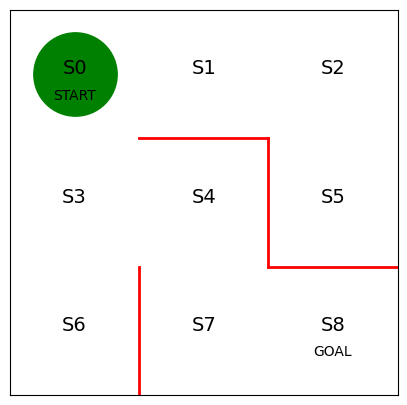

In [2]:
# 전체 그림의 크기 및 그림을 나타내는 변수 선언
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 붉은 벽 그리기
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 각 좌표의 상태를 의미하는 문자열(S0~S8) 표시
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 그림을 그릴 범위 및 눈금 제거 설정
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, right=False, left=False, labelleft=False)

# S0에 녹색 원으로 현재 위치를 표시
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

### 정책을 결정하는 파라미터의 초깃값 theta_0를 설정

In [3]:
# 줄은 상태 0~7, 열은 행동방향(상,우,하,좌 순)를 나타낸다
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8은 목표지점이므로 정책이 없다
                    ])

### 정책 파라미터 theta를 행동정책 pi로 변환(소프트맥스 함수 사용)하는 함수

In [4]:
def softmax_convert_into_pi_from_theta(theta):
    '''비율 계산에 소프트맥스 함수 사용'''

    beta = 1.0
    [m, n] = theta.shape  # theta의 행렬 크기를 구함
    pi = np.zeros((m, n))

    exp_theta = np.exp(beta * theta)  # theta를 exp(theta)로 변환

    for i in range(0, m):
        # pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        # 단순 비율을 계산하는 코드

        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        # softmax로 계산하는 코드

    pi = np.nan_to_num(pi)  # nan을 0으로 변환

    return pi

In [39]:
# 초기 정책 pi_0을 계산
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


### 행동 a를 취한 후의 상태 s를 구하는 함수

In [8]:
def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    # pi[s,:]의 확률을 따라, direction값이 선택된다
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 위로 이동하면 상태값이 3 줄어든다
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 오른쪽으로 이동하면 상태값이 1 늘어난다
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 아래로 이동하면 상태값이 3 늘어난다
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 왼쪽으로 이동하면 상태값이 1 줄어든다

    return [action, s_next]

### 목표 지점에 이를 때까지 에이전트를 계속 이동시키는 함수

In [9]:
def goal_maze_ret_s_a(pi):
    s = 0  # 시작 지점
    s_a_history = [[0, np.nan]]  # 에이전트의 행동 및 상태의 히스토리를 기록하는 리스트

    while (1):  # 목표 지점에 이를 때까지 반복
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        # 현재 상태(마지막이므로 인덱스가 -1)를 히스토리에 추가

        s_a_history.append([next_s, np.nan])
        # 다음 상태를 히스토리에 추가, 행동은 아직 알 수 없으므로 nan으로 둔다.

        if next_s == 8:  # 목표 지점에 이르면 종료
            break
        else:
            s = next_s

    return s_a_history

### 초기 정책으로 미로를 빠져나오기

In [27]:
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(s_a_history) - 1) + "단계입니다")

[[0, 1], [1, 1], [2, 2], [5, 0], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 1], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 1], [4, 2], [7, 1], [8, nan]]
목표 지점에 이르기까지 걸린 단계 수는 42단계입니다


## 정책경사 알고리즘으로 정책 수정

### theta를 수정하는 함수

In [28]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1 # 학습률
    T = len(s_a_history) - 1  # 목표 지점에 이르기까지 걸린 단계 수

    [m, n] = theta.shape  # theta의 행렬 크기를 구함
    delta_theta = theta.copy()  # Δtheta를 구할 준비, 포인터 참조이므로 delta_theta = theta로는 안됨

    # delta_theta를 요소 단위로 계산
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan(theta[i, j])):  # theta가 nan이 아닌 경우

                SA_i = [SA for SA in s_a_history if SA[0] == i]
                # 히스토리에서 상태 i인 것만 모아오는 리스트 컴프리헨션

                SA_ij = [SA for SA in s_a_history if SA == [i, j]]
                # 상태 i에서 행동 j를 취한 경우만 모음

                N_i = len(SA_i)  # 상태 i에서 모든 행동을 취한 횟수
                N_ij = len(SA_ij)  # 상태 i에서 행동 j를 취한 횟수 
                
                # 초판에서 부호 오류가 있었음(수정일 : 1807030
                #delta_theta[i, j] = (N_ij + pi[i, j] * N_i) / T
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T

    new_theta = theta + eta * delta_theta

    return new_theta

### 정책 수정

In [40]:
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[0.         0.50119047 0.49880953 0.        ]
 [0.         0.50059524 0.         0.49940476]
 [0.         0.         0.50476176 0.49523824]
 [0.33306868 0.33386264 0.33306868 0.        ]
 [0.         0.         0.50059524 0.49940476]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.49940476 0.50059524 0.         0.        ]]


### 정책 경사 알고리즘으로 미로 빠져나오기

In [41]:
stop_epsilon = 10**-4  # 정책의 변화가 10^-4 보다 작아지면 학습을 종료


theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:  # is_continue가 False가 될 때까지 반복
    s_a_history = goal_maze_ret_s_a(pi)  # 정책 π를 따라 미로를 탐색한 히스토리를 구함
    new_theta = update_theta(theta, pi, s_a_history)  # 파라미터 Θ를 수정
    new_pi = softmax_convert_into_pi_from_theta(new_theta)  # 정책 π를 수정

    print(np.sum(np.abs(new_pi - pi)))  # 정책의 변화를 출력
    print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(s_a_history) - 1) + "단계입니다")

    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

0.008276956716709749
목표 지점에 이르기까지 걸린 단계 수는 92단계입니다
0.0059397052840469144
목표 지점에 이르기까지 걸린 단계 수는 48단계입니다
0.005277126223075745
목표 지점에 이르기까지 걸린 단계 수는 104단계입니다
0.01290381998929302
목표 지점에 이르기까지 걸린 단계 수는 42단계입니다
0.014566555240207446
목표 지점에 이르기까지 걸린 단계 수는 20단계입니다
0.017085021656528088
목표 지점에 이르기까지 걸린 단계 수는 26단계입니다
0.016775216107070112
목표 지점에 이르기까지 걸린 단계 수는 16단계입니다
0.004999700683151587
목표 지점에 이르기까지 걸린 단계 수는 76단계입니다
0.01122544913243323
목표 지점에 이르기까지 걸린 단계 수는 26단계입니다
0.0092101453233418
목표 지점에 이르기까지 걸린 단계 수는 92단계입니다
0.025122640598997048
목표 지점에 이르기까지 걸린 단계 수는 8단계입니다
0.048290944387497925
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.007684008491160521
목표 지점에 이르기까지 걸린 단계 수는 106단계입니다
0.007016816165252793
목표 지점에 이르기까지 걸린 단계 수는 56단계입니다
0.02660299450935838
목표 지점에 이르기까지 걸린 단계 수는 20단계입니다
0.0069063564517218845
목표 지점에 이르기까지 걸린 단계 수는 64단계입니다
0.01079142162812069
목표 지점에 이르기까지 걸린 단계 수는 76단계입니다
0.025168447299652563
목표 지점에 이르기까지 걸린 단계 수는 22단계입니다
0.029556301468338597
목표 지점에 이르기까지 걸린 단계 수는 10단계입니다
0.013755410947798141
목표 지점에 이르기까지 걸

0.021035104907498492
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.019609789420981183
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.02065050859106715
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.02035983557673507
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.02007366249704326
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.015041018051605543
목표 지점에 이르기까지 걸린 단계 수는 8단계입니다
0.01978595872283312
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.02391220512875039
목표 지점에 이르기까지 걸린 단계 수는 20단계입니다
0.01662021054024493
목표 지점에 이르기까지 걸린 단계 수는 8단계입니다
0.019455230396542983
목표 지점에 이르기까지 걸린 단계 수는 22단계입니다
0.019860536111549698
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.014057912755954222
목표 지점에 이르기까지 걸린 단계 수는 8단계입니다
0.01733393501974212
목표 지점에 이르기까지 걸린 단계 수는 14단계입니다
0.0161013725437629
목표 지점에 이르기까지 걸린 단계 수는 10단계입니다
0.019695787105548535
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.019418300760231738
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.023072726479740985
목표 지점에 이르기까지 걸린 단계 수는 12단계입니다
0.014561154954151112
목표 지점에 이르기까지 걸린 단계 수는 50단계입니다
0.019350385783830665
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.01907889849460459
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.01

0.003737076716322396
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.003706034433649197
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.006165366113557627
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.003694894063735202
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0036643569905344675
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.006099092457532401
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.007480151164093882
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.007371893007900601
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.0037013713150766403
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.01033689042464618
목표 지점에 이르기까지 걸린 단계 수는 8단계입니다
0.003727998658058382
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.007452439187972573
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.00750365661426651
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.008573664788257843
목표 지점에 이르기까지 걸린 단계 수는 8단계입니다
0.003809703986077509
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0037774341778475523
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.006185719081222521
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.007566521430444811
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.006198915075733044
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.003820869481345135
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다

0.0009987810419313792
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0036537103043836824
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.0010051922311149833
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.001000399607169862
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009956412593730979
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009909168612689534
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009862260902768274
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009815686276363651
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.000976944158354063
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009723523711485764
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009677929583995458
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009632656160972267
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009587700437891505
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009543059445322848
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.004225996291000258
목표 지점에 이르기까지 걸린 단계 수는 8단계입니다
0.003113071497159864
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.00533321942881948
목표 지점에 이르기까지 걸린 단계 수는 8단계입니다
0.0009960270949500097
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009913096536589144
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0009866256389000766
목표 지점에 이르기까지 걸린

0.0001791806721816204
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.000178797622254959
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.001795582249920111
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.00018271534168778393
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.00018231772156968376
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.00018192144745626977
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0001815265130890465
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0001811329122451133
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.00018074063873828143
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.00018034968642179246
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.00017996004918175573
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0001795717209429979
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0018224169155359928
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다
0.00018364662842339056
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.00018324284224970414
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.00018284044326231756
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0001824394248928548
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.0001820397806135115
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.00018164150393510693
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다
0.00018124458840848567


### 학습이 끝난 정책을 확인

In [42]:
np.set_printoptions(precision=3, suppress=True)  # 유효 자릿수 3, 지수 표시하지 않는다는 설정
print(pi)

[[0.    0.013 0.987 0.   ]
 [0.    0.317 0.    0.683]
 [0.    0.    0.421 0.579]
 [0.009 0.981 0.009 0.   ]
 [0.    0.    0.983 0.017]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.018 0.982 0.    0.   ]]


### 에이전트의 이동 과정을 시각화

In [43]:
from matplotlib import animation
from IPython.display import HTML


def init():
    # 배경 이미지 초기화
    line.set_data([], [])
    return (line,)


def animate(i):
    # 프레임 단위로 이미지 생성
    state = s_a_history[i][0]  # 현재 위치
    x = (state % 3) + 0.5  # 상태의 x좌표 : 3으로 나눈 나머지 + 0.5
    y = 2.5 - int(state / 3)  # y좌표 : 2.5에서 3으로 나눈 몫을 뺌
    line.set_data(x, y)
    return (line,)


#　초기화 함수와 프레임 단위 이미지 생성한수를 사용하여 애니메이션 생성
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())